## Import

In [1]:
!pip install numpy
!pip install matplotlib
!pip install seaborn

import numpy as np
from math import log, ceil
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Set parameters

In [2]:
mean_gen = 4.5
std_gen = 3

random_seed = 0  # 실험 결과 분석을 위한 랜덤 시드 고정

src_sym_seq_len_candidate = [1,10,100,1000,10000,100000,1000000]
src_alphabets = set(range(10))

avg_bit_per_symbol_result = dict()

## Generation source symbol sequence

In [3]:
def src_sym_gnerator(src_alphabets, mean_gen, std_gen, src_sym_seq_len):

    src_sym_seq = np.array(np.round(np.random.normal(loc = mean_gen, scale = std_gen, size=(src_sym_seq_len)), 0),dtype='int8')  # 가우스 분포를 따르는 랜덤 심볼 시퀀스 생성 및 반올림을 통해 정수로 고정
    src_sym_seq = src_sym_seq.clip(0,9)  # Decimal 을 제외한 수  bound 고정: min 0, max 9

    return src_sym_seq

def find_sym_prob(src_sym_seq):
    sym_prob = {sym: num_of_sym/len(src_sym_seq) for (sym, num_of_sym) in zip(*np.unique(src_sym_seq, return_counts=True))}
    return sym_prob

## Init dictionary

In [4]:
def initalize_dic(src_alphabets):
    init_dic = [(0,sym) for sym in [None]+list(src_alphabets)]
    return init_dic

## Encoder

In [5]:
def encoding(src_alphabets, src_sym_seq):
    transmitted_codewords = list()
    encoder_dic = initalize_dic(src_alphabets)
    n = 0

    for current_seq_idx, current_sym in enumerate(src_sym_seq):
        if (n,current_sym) in encoder_dic:
            n = encoder_dic.index((n,current_sym))
        else:
            transmitted_codewords.append(n)
            encoder_dic.append((n,current_sym))
            n = encoder_dic.index((0,current_sym))

    transmitted_codewords.append(n)  # 마지막 n 추가

    return transmitted_codewords, encoder_dic

## Decoder

In [6]:
def decoding(src_alphabets, received_codewords):
    def codeword_2_sym_seq(decoder_dic, ptr):
        sym_seq = list()
        while ptr != 0:
            sym_seq.append(decoder_dic[ptr][1])
            ptr = decoder_dic[ptr][0]
        sym_seq.reverse()
        return sym_seq

    decoder_dic = initalize_dic(src_alphabets)
    decoded_sym_seq = list()
    prev_codeword = None

    for current_codeword_index in range(len(received_codewords)):
        # current_codeword_index 에 대해
        current_codeword = received_codewords[current_codeword_index]
        current_ptr = current_codeword  # 직전에 추가되었어야 하는 dic element에 대응 어려움
        try:
            # current_ptr이 존재하는 경우
            tmp_seq = codeword_2_sym_seq(decoder_dic, current_ptr)
        except:
            # current_ptr이 존재하지 않는 경우..

            # 직전에 추가되었어야 하는 dic element를 바로 참조했을 때 오류 발생
            # 우선 해당 dic element를 먼저 decoder_dic에 추가
            tmp_seq = codeword_2_sym_seq(decoder_dic, prev_codeword)
            prev_dic_element = (prev_codeword, tmp_seq[0])  # 임의로 먼저 추가
            decoder_dic.append(prev_dic_element)
            prev_codeword = None  # 중복 추가 못 하도록 조건 걸음

            # 동일 작업 수행
            tmp_seq = codeword_2_sym_seq(decoder_dic, current_ptr)

        decoded_sym_seq = decoded_sym_seq + tmp_seq

        # 이전 codeword에 해당하는 dic element 추가
        if prev_codeword != None:
            prev_dic_element = (prev_codeword, tmp_seq[0])
            decoder_dic.append(prev_dic_element)

        prev_codeword = current_codeword
    return decoded_sym_seq, decoder_dic

In [7]:
def verification(src_sym_seq, decoded_sym_seq, encoder_dic, decoder_dic):
    dic_error = False
    if encoder_dic != decoder_dic:
        print('생성한 딕셔너리가 서로 다름')
        dic_error = True

    error_count = 0
    for boolean in decoded_sym_seq != src_sym_seq:
        if boolean:
            print('error')
            error_count += 1

    return dic_error, error_count

## Main

In [8]:
def main(src_alphabets, src_sym_seq_len, mean_gen, std_gen, random_seed = None,):
    np.random.seed(random_seed)  # 실험 결과 분석을 위한 랜덤 시드 고정

    src_sym_seq = src_sym_gnerator(src_alphabets, mean_gen, std_gen, src_sym_seq_len)
    sym_prob = find_sym_prob(src_sym_seq)

    src_entropy = 0
    for each_sym_prob in sym_prob.values():
        src_entropy += each_sym_prob*log(1/each_sym_prob,2)
    
    transmitted_codewords, encoder_dic = encoding(src_alphabets, src_sym_seq)
    decoded_sym_seq, decoder_dic = decoding(src_alphabets, received_codewords = transmitted_codewords)

    dic_error, error_count = verification(src_sym_seq, decoded_sym_seq, encoder_dic, decoder_dic)

    result_dic = {
        'src_sym_seq_len' : src_sym_seq_len,
        'src_sym_seq' : src_sym_seq,
        'sym_prob' : sym_prob,
        'src_entropy' : src_entropy,
        'transmitted_codewords' : transmitted_codewords,
        'encoder_dic' : encoder_dic,
        'decoded_sym_seq' : decoded_sym_seq,
        'decoder_dic' : decoder_dic,
        'dic_error' : dic_error,
        'error_count' : error_count,
        'avg_bit_per_symbol' : ceil(log(len(encoder_dic),2)) * len(transmitted_codewords) / src_sym_seq_len,

    }
    return result_dic

## 결과 분석

In [9]:
save_path = 'C:/NAS/간단백업/충남대학교/충대2022/4학년 2학기/정보및부호이론/과제/실험'

for src_sym_seq_len in src_sym_seq_len_candidate:
    file_name = f'seq_len{src_sym_seq_len}.pickle'
    each_result = main(src_alphabets, src_sym_seq_len, mean_gen, std_gen, random_seed = random_seed)
    with open(f'{save_path}/{file_name}','wb') as fw:
        pickle.dump(each_result, fw)
    avg_bit_per_symbol_result[src_sym_seq_len] = each_result['avg_bit_per_symbol']

with open(f'{save_path}/avg_bit_per_symbol_result.pickle','wb') as fw:
    pickle.dump(avg_bit_per_symbol_result, fw)

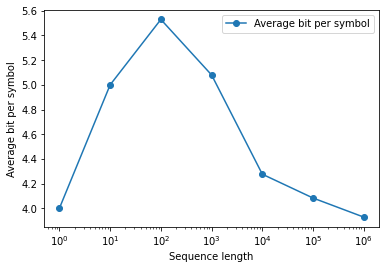

{1: 4.0,
 10: 5.0,
 100: 5.53,
 1000: 5.08,
 10000: 4.2756,
 100000: 4.08255,
 1000000: 3.92787}

In [10]:
plt.figure()
plt.plot(avg_bit_per_symbol_result.keys(),avg_bit_per_symbol_result.values(),'o-',label='Average bit per symbol')
plt.xscale('log')
plt.xlabel('Sequence length')
plt.ylabel('Average bit per symbol')
plt.legend()
plt.show()
avg_bit_per_symbol_result

## 저장된 결과 불러와서 분석

In [11]:
save_path = 'C:/NAS/간단백업/충남대학교/충대2022/4학년 2학기/정보및부호이론/과제/실험'

total_result = list()

for src_sym_seq_len in src_sym_seq_len_candidate:
    file_name = f'seq_len{src_sym_seq_len}.pickle'
    with open(f'{save_path}/{file_name}','rb') as fr:
        total_result.append(pickle.load(fr))

with open(f'{save_path}/avg_bit_per_symbol_result.pickle','rb') as fr:
        avg_bit_per_symbol_result = pickle.load(fr)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14704\851202282.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(total_result[-1]['sym_prob'].keys(),total_result[-1]['sym_prob'].values(),'o',label='symbol probability')


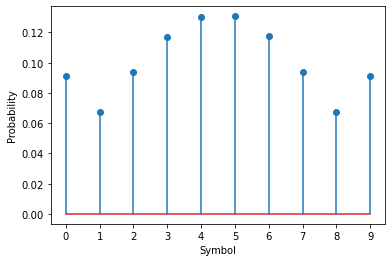

In [12]:
# 생성된 심볼 순열의 시각화
plt.figure()
plt.stem(total_result[-1]['sym_prob'].keys(),total_result[-1]['sym_prob'].values(),'o',label='symbol probability')
plt.xticks(list(total_result[-1]['sym_prob'].keys()))
plt.xlabel('Symbol')
plt.ylabel('Probability')
# plt.legend()
plt.show()



In [15]:
[dic['src_sym_seq_len'] for dic in total_result]

[1, 10, 100, 1000, 10000, 100000, 1000000]

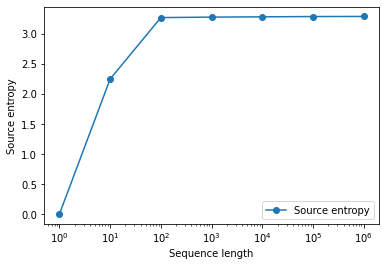

In [20]:
plt.figure()
plt.plot([dic['src_sym_seq_len'] for dic in total_result],[dic['src_entropy'] for dic in total_result],'o-',label='Source entropy')
plt.xscale('log')
plt.xlabel('Sequence length')
plt.ylabel('Source entropy')
plt.legend()
plt.show()

In [17]:
# # 생성된 심볼 순열의 시각화
# plt.figure()
# plt.stem(sym_prob.keys(),sym_prob.values(),'o',label='symbol probability')
# plt.xticks(list(sym_prob.keys()))
# plt.xlabel('Symbol')
# plt.ylabel('Probability')
# plt.legend()

In [18]:
# src_entropy = 0
# for each_sym_prob in sym_prob.values():
#     src_entropy += each_sym_prob*log(1/each_sym_prob,2)
# src_entropy

In [19]:
# # efficiency without source coding
# # src_entropy / avg # of binary digits for src data
# src_entropy / 4